In [3]:
# imports
import pandas as pd
import os
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
from keras import layers
from keras import models
from keras import regularizers
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img, img_to_array, load_img
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelBinarizer
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from scikeras.wrappers import KerasClassifier, KerasRegressor
from sklearn.metrics import classification_report
import tensorflow.keras as keras
import PIL.Image as Image
import lime

#import tensorflow_addons as tfa
#import tensorflow_datasets as tdfs

### Function to visualize model performance

This function plots the loss and accuracy of both training and validation data across the epochs.

In [4]:
def visualize_training_results(results):
    history = results.history
    plt.figure(figsize=(6, 4))
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure(figsize=(6, 4))
    plt.plot(history['val_acc'])
    plt.plot(history['acc'])
    plt.legend(['val_acc', 'acc'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()


### Preprocess images

In [13]:
train_data_dir = 'data/short'

# Get all the data in the directory data/train (790 images), and reshape them
train_generator = ImageDataGenerator().flow_from_directory(
        train_data_dir, 
        target_size=(128, 128), batch_size=1500)

# Create the datasets
train_images, y_train = next(train_generator)


Found 1500 images belonging to 5 classes.


#### preview image labels

In [14]:
y_train

array([[0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.]], dtype=float32)

The labels are already in a format suited for modeling.

In [15]:
y_train[17]

array([0., 0., 1., 0., 0.], dtype=float32)

In [16]:
# preview shape
print(np.shape(train_images))
print(np.shape(y_train))

(1500, 128, 128, 3)
(1500, 5)


### reshape images

The images must be reshaped into a tensor before being input into a neural network model.

In [17]:
train_img_unrow = train_images.reshape(1500, -1)#.astype(uint8)

# Preview the shape of train_img_unrow
print(np.shape(train_img_unrow))

(1500, 49152)


#### normalize pixel values

In [18]:
train_img_unrow /= 255.

# Binary labeling

Label the data as belonging to one of 2 classes, healthy or diseased.

In [19]:
# make dataframe and preview
df = pd.DataFrame(y_train)
df

,0,1,2,3,4
0,0.0,0.0,0.0,0.0,1.0
1,0.0,1.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...
1495,0.0,0.0,0.0,1.0,0.0
1496,0.0,1.0,0.0,0.0,0.0
1497,0.0,1.0,0.0,0.0,0.0
1498,0.0,0.0,0.0,1.0,0.0


In [20]:
# copy the dataframe
new=df.copy()

new


,0,1,2,3,4
0,0.0,0.0,0.0,0.0,1.0
1,0.0,1.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...
1495,0.0,0.0,0.0,1.0,0.0
1496,0.0,1.0,0.0,0.0,0.0
1497,0.0,1.0,0.0,0.0,0.0
1498,0.0,0.0,0.0,1.0,0.0


In [21]:
new.loc[new[4]==1,"Healthy"]=1
new.loc[new[4]==0,"Healthy"]=0
new.loc[new[4]==1,"Diseased"]=0
new.loc[new[4]==0,"Diseased"]=1
new

,0,1,2,3,4,Healthy,Diseased
0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...
1495,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1496,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1497,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1498,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [22]:
new.drop([0, 1, 2, 3, 4], axis=1, inplace=True)

In [23]:
new.tail(5)

,Healthy,Diseased
1495,0.0,1.0
1496,0.0,1.0
1497,0.0,1.0
1498,0.0,1.0
1499,0.0,1.0


In [24]:
# check for any null entries
new.isnull().sum()

Healthy     0
Diseased    0
dtype: int64

In [25]:
new['Healthy'].sum()


300.0

In [26]:
new['Diseased'].sum()


1200.0

<AxesSubplot:>

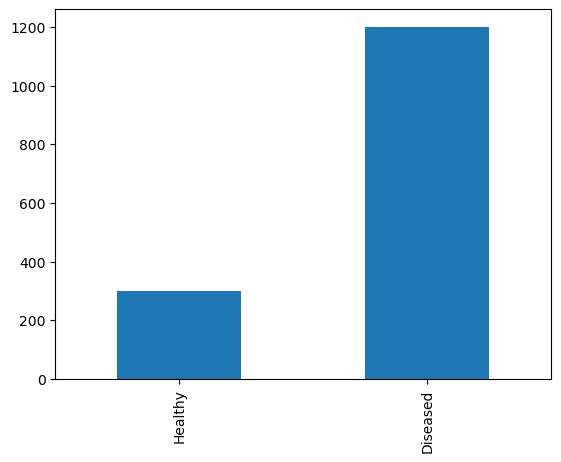

In [27]:
new.sum().plot(kind='bar')

# Modeling

### *** Run all above*** for data preparation. The following cells may take a while to run.

## img class w MLPs

## train-test split

In [28]:
final_train, final_test, train_labels, test_labels= train_test_split(train_img_unrow, y_train, test_size=0.2, random_state=42,shuffle=True)


In [33]:
#instantiate and train model  -12288 input shape if 64 pix   196608 if 256     49152
np.random.seed(42)
model_1 = models.Sequential()
model_1.add(layers.Dense(256, activation='tanh', input_shape=(49152,)))
model_1.add(layers.Dense(5, activation='softmax'))

model_1.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc'])
model_1.summary()
results_1 = model_1.fit(final_train, 
                        train_labels,
                        epochs=10,
                        batch_size=12,
                        validation_data=(final_test, test_labels))


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 256)               12583168  
                                                                 
 dense_3 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 12584453 (48.01 MB)
Trainable params: 12584453 (48.01 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10


100/100 [==============================] - 6s 57ms/step - loss: 1.9626 - acc: 0.2125 - val_loss: 1.6167 - val_acc: 0.2533
Epoch 2/10
100/100 [==============================] - 6s 57ms/step - loss: 1.6505 - acc: 0.2317 - val_loss: 1.6352 - val_acc: 0.2167
Epoch 3/10
100/100 [==============================] - 6s 59ms/step - loss: 1.6596 - acc: 0.2233 - val_loss: 1.5939 - val_acc: 0.2167
Epoch 4

In [34]:
y_pred = model_1.predict(final_test)

10/10 [==============================] - 0s 13ms/step


In [35]:
print(classification_report(np.argmax(test_labels, axis=1), np.argmax(y_pred, axis=1)))

              precision    recall  f1-score   support

           0       0.25      0.76      0.38        55
           1       0.00      0.00      0.00        61
           2       0.67      0.03      0.06        69
           3       0.00      0.00      0.00        66
           4       0.21      0.55      0.30        49

    accuracy                           0.24       300
   macro avg       0.23      0.27      0.15       300
weighted avg       0.23      0.24      0.13       300



C:\Users\lalyn\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\lalyn\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\lalyn\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


With a training accuracy of 48.5% and testing accuracy of 47%, there is lots of room for improvement. 

In [ ]:
visualize_training_results(results_1)








## Convoluted Neural Network (CNN) model

CNN models are known to perform well on image recognition tasks.

# Resume here**************************

In [81]:
cnn_train, cnn_test, cnn_train_labels, cnn_test_labels= train_test_split(train_images, y_train, test_size=0.2, random_state=42,shuffle=True)


In [180]:
np.random.seed(42)
cnn_model = models.Sequential()
cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(128, 128, 3))) 
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(32, (4, 4), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(64, activation='relu'))
cnn_model.add(layers.Dense(5, activation='sigmoid'))

cnn_model.compile(loss='categorical_crossentropy',
              optimizer="sgd",
              metrics=['acc', 'AUC'])
cnn_results = cnn_model.fit(cnn_train,
                            cnn_train_labels, 
                            epochs=10,
                            batch_size=16,
                            validation_data=(cnn_test, cnn_test_labels))

Epoch 1/10
75/75 [==============================] - 13s 166ms/step - loss: 1.6148 - acc: 0.2042 - auc: 0.5080 - val_loss: 1.5993 - val_acc: 0.3067 - val_auc: 0.5722
Epoch 2/10
75/75 [==============================] - 11s 150ms/step - loss: 1.6004 - acc: 0.2517 - auc: 0.5510 - val_loss: 1.6142 - val_acc: 0.2000 - val_auc: 0.5001
Epoch 3/10
75/75 [==============================] - 12s 165ms/step - loss: 1.5905 - acc: 0.2433 - auc: 0.5754 - val_loss: 1.5956 - val_acc: 0.2000 - val_auc: 0.5542
Epoch 4/10
75/75 [==============================] - 10s 131ms/step - loss: 1.5737 - acc: 0.2650 - auc: 0.6134 - val_loss: 1.5654 - val_acc: 0.3200 - val_auc: 0.6323
Epoch 5/10
75/75 [==============================] - 10s 133ms/step - loss: 1.5645 - acc: 0.2700 - auc: 0.6141 - val_loss: 1.5756 - val_acc: 0.2533 - val_auc: 0.5864
Epoch 6/10
75/75 [==============================] - 9s 123ms/step - loss: 1.5456 - acc: 0.3000 - auc: 0.6276 - val_loss: 1.5429 - val_acc: 0.3033 - val_auc: 0.6305
Epoch 7/10


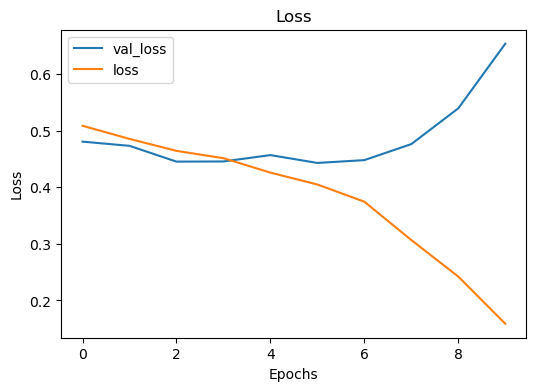

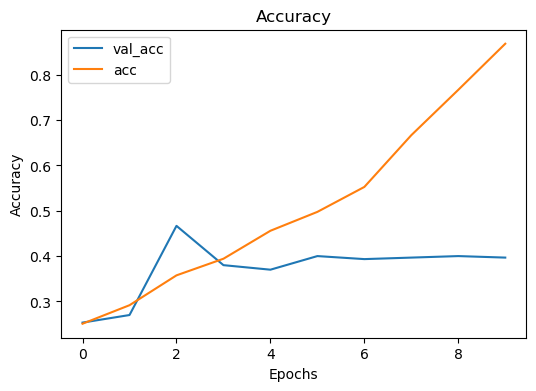

In [51]:
visualize_training_results(cnn_results)

In [181]:
y_pred = cnn_model.predict(cnn_test)

10/10 [==============================] - 1s 59ms/step


In [182]:
print(classification_report(cnn_test_labels, np.round(y_pred)))

              precision    recall  f1-score   support

           0       0.47      0.49      0.48        55
           1       0.38      0.59      0.46        61
           2       0.30      0.87      0.45        69
           3       0.32      0.91      0.48        66
           4       0.42      0.10      0.16        49

   micro avg       0.34      0.63      0.44       300
   macro avg       0.38      0.59      0.41       300
weighted avg       0.37      0.63      0.42       300
 samples avg       0.34      0.63      0.43       300



C:\Users\lalyn\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The model performs very well on the training data, yet not nearly as well on the validation data. Nevertheless, it is still an imporvement from the previous models.

# Binary classification

While it is ideal to be able to identify specific diseases, detecting disease is an important first step. This next section seeks to classify images into one of two classes, healthy and diseased. 

# Modeling

In [54]:
binary_train, binary_test, binary_train_labels, binary_test_labels= train_test_split(train_img_unrow, new, test_size=0.2, random_state=42,shuffle=True)


### basic network binary

In [183]:
#instantiate model
#np.random.seed(42)
binary_model_1 = models.Sequential()
binary_model_1.add(layers.Dense(256, activation='tanh', input_shape=(49152,)))
binary_model_1.add(layers.Dense(2, activation='softmax'))

binary_model_1.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['AUC', 'acc'])


In [184]:
binary_model_1.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_69 (Dense)            (None, 256)               12583168  
                                                                 
 dense_70 (Dense)            (None, 2)                 514       
                                                                 
Total params: 12583682 (48.00 MB)
Trainable params: 12583682 (48.00 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [185]:
binary_results_1 = binary_model_1.fit(binary_train, 
                        binary_train_labels,
                        epochs=10,
                        batch_size=16,
                        validation_data=(binary_test, binary_test_labels))

Epoch 1/10
75/75 [==============================] - 7s 71ms/step - loss: 0.5595 - auc: 0.8044 - acc: 0.7808 - val_loss: 0.4460 - val_auc: 0.8683 - val_acc: 0.8367
Epoch 2/10
75/75 [==============================] - 4s 59ms/step - loss: 0.5106 - auc: 0.8116 - acc: 0.7900 - val_loss: 0.4328 - val_auc: 0.8759 - val_acc: 0.8367
Epoch 3/10
75/75 [==============================] - 4s 58ms/step - loss: 0.4970 - auc: 0.8315 - acc: 0.7900 - val_loss: 0.4300 - val_auc: 0.8763 - val_acc: 0.8367
Epoch 4/10
75/75 [==============================] - 5s 62ms/step - loss: 0.4905 - auc: 0.8401 - acc: 0.7883 - val_loss: 0.4262 - val_auc: 0.8836 - val_acc: 0.8367
Epoch 5/10
75/75 [==============================] - 5s 69ms/step - loss: 0.4799 - auc: 0.8493 - acc: 0.7883 - val_loss: 0.4162 - val_auc: 0.8848 - val_acc: 0.8367
Epoch 6/10
75/75 [==============================] - 4s 56ms/step - loss: 0.4744 - auc: 0.8524 - acc: 0.7950 - val_loss: 0.4389 - val_auc: 0.8853 - val_acc: 0.8367
Epoch 7/10
75/75 [====

With a training accuracy of 48.5% and testing accuracy of 47%, there is lots of room for improvement. 

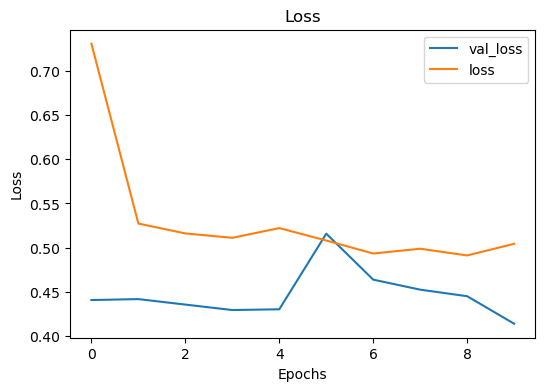

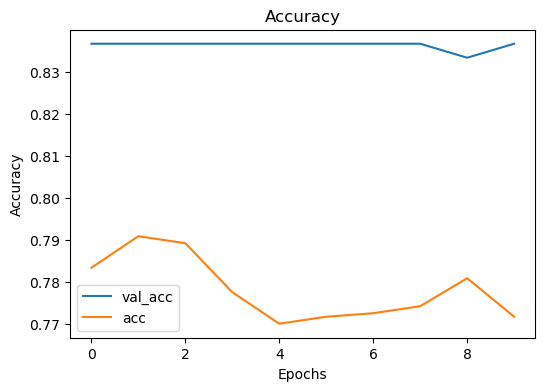

In [58]:
visualize_training_results(binary_results_1)

comments.....

In [186]:
bin_y_pred = binary_model_1.predict(binary_test)

10/10 [==============================] - 0s 17ms/step


In [187]:
print(classification_report(binary_test_labels, np.round(bin_y_pred)))

              precision    recall  f1-score   support

           0       0.56      0.10      0.17        49
           1       0.85      0.98      0.91       251

   micro avg       0.84      0.84      0.84       300
   macro avg       0.70      0.54      0.54       300
weighted avg       0.80      0.84      0.79       300
 samples avg       0.84      0.84      0.84       300



### grid search to find best params in binary model

In [192]:
def buildModel_binary(optimizer):
    # Initialising the ANN
    classifier = models.Sequential()
    
    # Adding the input layer and the first hidden layer
    classifier.add(layers.Dense(128, activation = 'relu', input_shape=(49152,)))
        
    # Adding the output layer
    classifier.add(layers.Dense(2, activation='sigmoid'))
    
    # Compiling the ANN
    classifier.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['acc'])
    
    return classifier



In [194]:
binary_classifier = KerasRegressor(build_fn = buildModel_binary('adam'))
#What hyperparameter we want to play with
parameters = {'batch_size': [16],
              'epochs': [5, 10, 50],
              'optimizer': ['adam', 'sgd']}
binary_grid_search = GridSearchCV(estimator = binary_classifier,
                           param_grid = parameters,
                           scoring = 'neg_mean_absolute_error',
                           cv = 5)
binary_grid_search = binary_grid_search.fit(binary_train, binary_train_labels, verbose = 0)

INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp3luv1t5v\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp3luv1t5v\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpfazmv3cy\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpfazmv3cy\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 [==============================] - 0s 11ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpj03pf8io\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpj03pf8io\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 [==============================] - 0s 9ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpzch3_fkv\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpzch3_fkv\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 [==============================] - 0s 8ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmppky8gxcm\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmppky8gxcm\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 [==============================] - 0s 10ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp1_t1go9t\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp1_t1go9t\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 [==============================] - 0s 9ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp8r4ft65c\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp8r4ft65c\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 [==============================] - 0s 8ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpq7fzz3b8\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpq7fzz3b8\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 [==============================] - 0s 10ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpsrmdw1yw\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpsrmdw1yw\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 [==============================] - 0s 7ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpzbx0pz87\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpzbx0pz87\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 [==============================] - 0s 9ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp3zyw0v4k\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp3zyw0v4k\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 [==============================] - 0s 8ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp2elgidg9\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp2elgidg9\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 [==============================] - 0s 7ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpiewzotno\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpiewzotno\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 [==============================] - 0s 9ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpf7bxxfrm\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpf7bxxfrm\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 [==============================] - 0s 8ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpx822m0l7\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpx822m0l7\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 [==============================] - 0s 7ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp5i8sl497\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp5i8sl497\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 [==============================] - 0s 9ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpt8bg95rg\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpt8bg95rg\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 [==============================] - 0s 9ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpld2skuie\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpld2skuie\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 [==============================] - 0s 8ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpfr89s49h\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpfr89s49h\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 [==============================] - 0s 8ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp_kzmahuk\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp_kzmahuk\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 [==============================] - 0s 9ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpdva7vft6\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpdva7vft6\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 [==============================] - 0s 8ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpoaxry385\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpoaxry385\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 [==============================] - 0s 5ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpykcs4nzr\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpykcs4nzr\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 [==============================] - 0s 5ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp433eeqs3\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp433eeqs3\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 [==============================] - 0s 6ms/step


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpoqxrikvo\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpoqxrikvo\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 [==============================] - 0s 8ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmppaobegao\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmppaobegao\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 [==============================] - 0s 7ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpna22vd13\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpna22vd13\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 [==============================] - 0s 8ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpbothem26\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpbothem26\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 [==============================] - 0s 7ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpb5qj1b8a\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpb5qj1b8a\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 [==============================] - 0s 9ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpg6kgyzyg\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpg6kgyzyg\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 [==============================] - 0s 7ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp9tn06012\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp9tn06012\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 [==============================] - 0s 10ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpu3laf7pv\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpu3laf7pv\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmppliev12t\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmppliev12t\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


In [196]:
binary_best_parameters = binary_grid_search.best_params_
best_score = binary_grid_search.best_score_

print("Best Parameters: " + str(binary_best_parameters))

Best Parameters: {'batch_size': 16, 'epochs': 50, 'optimizer': 'adam'}


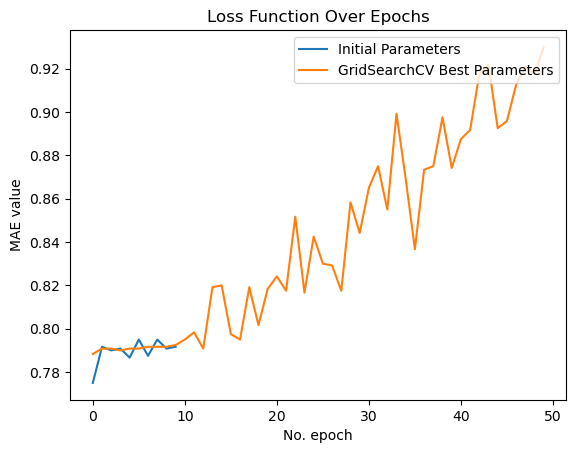

In [197]:
best_binary_Classifier = buildModel_binary('adam')
HistoryBest_binary = best_binary_Classifier.fit(binary_train, binary_train_labels, batch_size = 16, epochs =50 , verbose = 0)
plt.plot(binary_results_2.history['acc'], label='Initial Parameters')
plt.plot(HistoryBest_binary.history['acc'], label='GridSearchCV Best Parameters')
plt.title('Loss Function Over Epochs')
plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")
plt.show()

In [201]:
y_pred = best_binary_Classifier.predict(binary_test)

10/10 [==============================] - 0s 11ms/step


In [204]:
print(classification_report(binary_test_labels, np.round(y_pred)))

              precision    recall  f1-score   support

           0       0.40      0.45      0.42        49
           1       0.89      0.86      0.87       251

   micro avg       0.80      0.79      0.79       300
   macro avg       0.64      0.65      0.65       300
weighted avg       0.81      0.79      0.80       300
 samples avg       0.79      0.79      0.79       300



C:\Users\lalyn\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



## CNN model

In [29]:
cnn_binary_train, cnn_binary_test, cnn_binary_train_labels, cnn_binary_test_labels= train_test_split(train_images, new, test_size=0.2, random_state=42,shuffle=True)


In [207]:
np.random.seed(42)
binary_cnn_model = models.Sequential()
binary_cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(128, 128, 3))) 
binary_cnn_model.add(layers.MaxPooling2D((2, 2)))

binary_cnn_model.add(layers.Conv2D(32, (4, 4), activation='relu'))
binary_cnn_model.add(layers.MaxPooling2D((2, 2)))

binary_cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
binary_cnn_model.add(layers.MaxPooling2D((2, 2)))

binary_cnn_model.add(layers.Flatten())
binary_cnn_model.add(layers.Dense(64, activation='relu'))
binary_cnn_model.add(layers.Dense(2, activation='softmax'))

binary_cnn_model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['AUC', 'acc'])
binary_cnn_results = binary_cnn_model.fit(cnn_binary_train,
                            cnn_binary_train_labels,
                            epochs=10,
                            batch_size=16,
                            validation_data=(cnn_binary_test, cnn_binary_test_labels))

Epoch 1/10
75/75 [==============================] - 12s 139ms/step - loss: 0.5179 - auc: 0.8105 - acc: 0.7825 - val_loss: 0.4569 - val_auc: 0.8935 - val_acc: 0.8367
Epoch 2/10
75/75 [==============================] - 9s 119ms/step - loss: 0.5030 - auc: 0.8257 - acc: 0.7908 - val_loss: 0.4105 - val_auc: 0.9099 - val_acc: 0.8367
Epoch 3/10
75/75 [==============================] - 9s 122ms/step - loss: 0.4988 - auc: 0.8331 - acc: 0.7908 - val_loss: 0.4728 - val_auc: 0.8680 - val_acc: 0.8367
Epoch 4/10
75/75 [==============================] - 9s 120ms/step - loss: 0.4688 - auc: 0.8576 - acc: 0.7908 - val_loss: 0.3820 - val_auc: 0.9102 - val_acc: 0.8367
Epoch 5/10
75/75 [==============================] - 10s 128ms/step - loss: 0.4475 - auc: 0.8701 - acc: 0.7908 - val_loss: 0.3699 - val_auc: 0.9155 - val_acc: 0.8367
Epoch 6/10
75/75 [==============================] - 10s 130ms/step - loss: 0.4312 - auc: 0.8793 - acc: 0.7908 - val_loss: 0.3927 - val_auc: 0.9002 - val_acc: 0.8367
Epoch 7/10
75

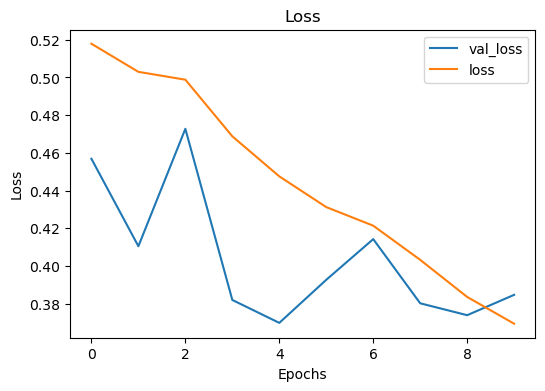

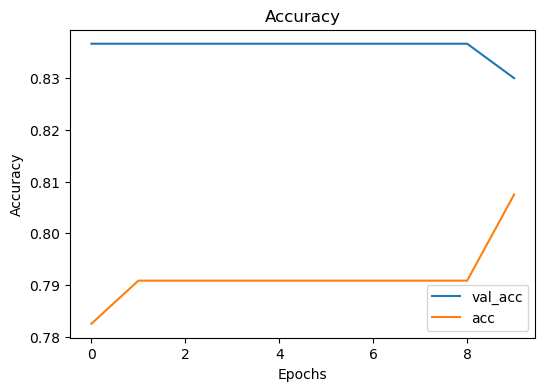

In [208]:
visualize_training_results(binary_cnn_results)

In [209]:

cnn_y_pred = binary_cnn_model.predict(cnn_binary_test)

10/10 [==============================] - 1s 58ms/step


In [210]:
print(classification_report(cnn_binary_test_labels, np.round(cnn_y_pred)))

              precision    recall  f1-score   support

           0       0.25      0.02      0.04        49
           1       0.84      0.99      0.91       251

   micro avg       0.83      0.83      0.83       300
   macro avg       0.54      0.50      0.47       300
weighted avg       0.74      0.83      0.76       300
 samples avg       0.83      0.83      0.83       300



# Pretrained model

Transfer learning consists of taking features learned on one problem, and leveraging them on a new, similar problem. For instance, features from a model that has learned to identify racoons may be useful to kick-start a model meant to identify tanukis.

Take layers from a previously trained model.
Freeze them, so as to avoid destroying any of the information they contain during future training rounds.
Add some new, trainable layers on top of the frozen layers. They will learn to turn the old features into predictions on a new dataset.
Train the new layers on your dataset.
A last, optional step, is fine-tuning, which consists of unfreezing the entire model you obtained above (or part of it), and re-training it on the new data with a very low learning rate. This can potentially achieve meaningful improvements, by incrementally adapting the pretrained features to the new data.

This leads us to how a typical transfer learning workflow can be implemented in Keras:

Instantiate a base model and load pre-trained weights into it.
Freeze all layers in the base model by setting trainable = False.
Create a new model on top of the output of one (or several) layers from the base model.
Train your new model on your new dataset.

known for its residual connections that help alleviate the vanishing gradient problem. S


In [30]:
from keras.applications import ResNet50V2

In [31]:
resnet = ResNet50V2(weights='imagenet', 
                 include_top=False, 
                 input_shape=(128, 128, 3))

In [32]:
resnet.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 134, 134, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 64, 64, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 66, 66, 64)           0         ['conv1_conv[0][0]']          
                                                                                         

 tchNormalization)                                                                                
                                                                                                  
 conv2_block3_preact_relu (  (None, 32, 32, 256)          0         ['conv2_block3_preact_bn[0][0]
 Activation)                                                        ']                            
                                                                                                  
 conv2_block3_1_conv (Conv2  (None, 32, 32, 64)           16384     ['conv2_block3_preact_relu[0][
 D)                                                                 0]']                          
                                                                                                  
 conv2_block3_1_bn (BatchNo  (None, 32, 32, 64)           256       ['conv2_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
          

 conv3_block2_1_relu (Activ  (None, 16, 16, 128)          0         ['conv3_block2_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv3_block2_2_pad (ZeroPa  (None, 18, 18, 128)          0         ['conv3_block2_1_relu[0][0]'] 
 dding2D)                                                                                         
                                                                                                  
 conv3_block2_2_conv (Conv2  (None, 16, 16, 128)          147456    ['conv3_block2_2_pad[0][0]']  
 D)                                                                                               
                                                                                                  
 conv3_block2_2_bn (BatchNo  (None, 16, 16, 128)          512       ['conv3_block2_2_conv[0][0]'] 
 rmalizati

                                                                                                  
 conv3_block4_3_conv (Conv2  (None, 8, 8, 512)            66048     ['conv3_block4_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block4_out (Add)      (None, 8, 8, 512)            0         ['max_pooling2d_1[0][0]',     
                                                                     'conv3_block4_3_conv[0][0]'] 
                                                                                                  
 conv4_block1_preact_bn (Ba  (None, 8, 8, 512)            2048      ['conv3_block4_out[0][0]']    
 tchNormalization)                                                                                
                                                                                                  
 conv4_blo

 D)                                                                 0]']                          
                                                                                                  
 conv4_block3_1_bn (BatchNo  (None, 8, 8, 256)            1024      ['conv4_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block3_1_relu (Activ  (None, 8, 8, 256)            0         ['conv4_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block3_2_pad (ZeroPa  (None, 10, 10, 256)          0         ['conv4_block3_1_relu[0][0]'] 
 dding2D)                                                                                         
          

 conv4_block5_2_relu (Activ  (None, 8, 8, 256)            0         ['conv4_block5_2_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block5_3_conv (Conv2  (None, 8, 8, 1024)           263168    ['conv4_block5_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv4_block5_out (Add)      (None, 8, 8, 1024)           0         ['conv4_block4_out[0][0]',    
                                                                     'conv4_block5_3_conv[0][0]'] 
                                                                                                  
 conv4_block6_preact_bn (Ba  (None, 8, 8, 1024)           4096      ['conv4_block5_out[0][0]']    
 tchNormal

                                                                                                  
 conv5_block2_preact_relu (  (None, 4, 4, 2048)           0         ['conv5_block2_preact_bn[0][0]
 Activation)                                                        ']                            
                                                                                                  
 conv5_block2_1_conv (Conv2  (None, 4, 4, 512)            1048576   ['conv5_block2_preact_relu[0][
 D)                                                                 0]']                          
                                                                                                  
 conv5_block2_1_bn (BatchNo  (None, 4, 4, 512)            2048      ['conv5_block2_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_blo

In [33]:
#instantiate and train model  -12288 input shape if 64 pix   196608 if 256     49152
np.random.seed(42)
res_model = models.Sequential()
res_model.add(resnet)
res_model.add(layers.Flatten())
res_model.add(layers.Dense(132, activation='relu'))
res_model.add(layers.Dense(5, activation='sigmoid'))


In [34]:
for layer in res_model.layers:
    print(layer.name, layer.trainable)
    
# Similarly, you can check how many trainable weights are in the model
print(len(res_model.trainable_weights))

resnet50v2 True
flatten True
dense True
dense_1 True
176


In [35]:
resnet.trainable = False

In [36]:
for layer in res_model.layers:
    print(layer.name, layer.trainable)
    
# Similarly, we can check how many trainable weights are in the model
print(len(res_model.trainable_weights))

resnet50v2 False
flatten True
dense True
dense_1 True
4


In [37]:
res_model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=2e-5),
              metrics=['acc'])

In [97]:
res_history = res_model.fit(cnn_train,
                    cnn_train_labels,
                    steps_per_epoch=27,
                    epochs=10,
                    validation_data=(cnn_test, cnn_test_labels),
                    validation_steps=10)



Epoch 1/10
27/27 [==============================] - 38s 1s/step - loss: 1.9464 - acc: 0.3200 - val_loss: 1.5191 - val_acc: 0.4100
Epoch 2/10
27/27 [==============================] - 37s 1s/step - loss: 1.1800 - acc: 0.5400 - val_loss: 1.3927 - val_acc: 0.4400
Epoch 3/10
27/27 [==============================] - 34s 1s/step - loss: 0.8694 - acc: 0.6808 - val_loss: 1.3395 - val_acc: 0.4633
Epoch 4/10
27/27 [==============================] - 49s 2s/step - loss: 0.6542 - acc: 0.7883 - val_loss: 1.3630 - val_acc: 0.4600
Epoch 5/10
27/27 [==============================] - 53s 2s/step - loss: 0.4953 - acc: 0.8675 - val_loss: 1.3793 - val_acc: 0.4533
Epoch 6/10
27/27 [==============================] - 47s 2s/step - loss: 0.3707 - acc: 0.9208 - val_loss: 1.3331 - val_acc: 0.5200
Epoch 7/10
27/27 [==============================] - 40s 2s/step - loss: 0.2745 - acc: 0.9575 - val_loss: 1.3341 - val_acc: 0.5000
Epoch 8/10
27/27 [==============================] - 44s 2s/step - loss: 0.2079 - acc: 0.97

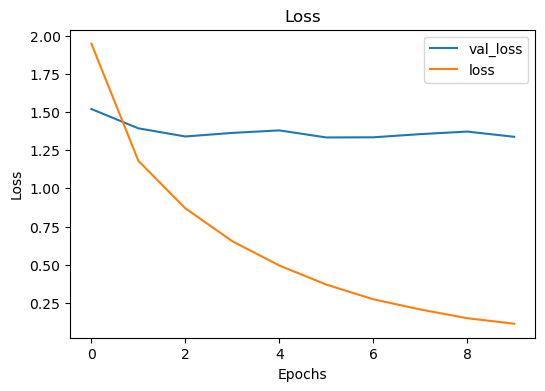

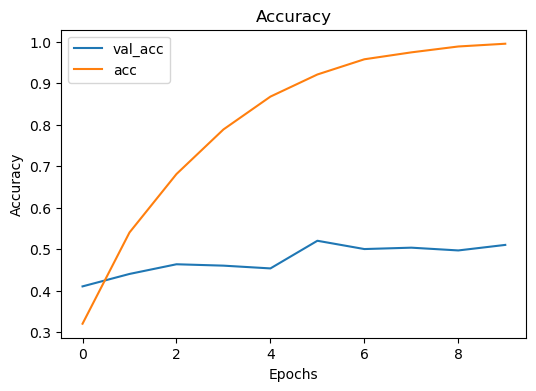

In [100]:
visualize_training_results(res_history)

In [98]:
y_pred = res_model.predict(cnn_test)

10/10 [==============================] - 7s 622ms/step


In [99]:
print(classification_report(cnn_test_labels, np.round(y_pred)))

              precision    recall  f1-score   support

           0       0.26      0.87      0.40        55
           1       0.28      0.82      0.42        61
           2       0.32      0.75      0.45        69
           3       0.40      0.94      0.56        66
           4       0.34      0.92      0.49        49

   micro avg       0.32      0.86      0.46       300
   macro avg       0.32      0.86      0.46       300
weighted avg       0.32      0.86      0.47       300
 samples avg       0.35      0.86      0.48       300



C:\Users\lalyn\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# pretrained binary model

In [160]:
#instantiate and train model  -12288 input shape if 64 pix   196608 if 256     49152
np.random.seed(42)
binary_res_model = models.Sequential()
binary_res_model.add(resnet)
binary_res_model.add(layers.Flatten())
binary_res_model.add(layers.Dense(132, activation='relu'))
binary_res_model.add(layers.Dense(2, activation='sigmoid'))


In [161]:
for layer in binary_res_model.layers:
    print(layer.name, layer.trainable)
    
# Similarly, you can check how many trainable weights are in the model
print(len(binary_res_model.trainable_weights))

resnet50v2 False
flatten_6 True
dense_48 True
dense_49 True
4


In [162]:
resnet.trainable = False

In [163]:
for layer in binary_res_model.layers:
    print(layer.name, layer.trainable)
    
# Similarly, we can check how many trainable weights are in the model
print(len(binary_res_model.trainable_weights))

resnet50v2 False
flatten_4 True
dense_41 True
dense_42 True
4


In [115]:
binary_res_model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=2e-5),
              metrics=['acc'])

In [116]:
binary_res_history = binary_res_model.fit(cnn_binary_train,
                    cnn_binary_train_labels,
                    steps_per_epoch=27,
                    epochs=10,
                    validation_data=(cnn_binary_test, cnn_binary_test_labels),                   
                    validation_steps=10)



Epoch 1/10
27/27 [==============================] - 35s 1s/step - loss: 0.5256 - acc: 0.7817 - val_loss: 0.3501 - val_acc: 0.8767
Epoch 2/10
27/27 [==============================] - 32s 1s/step - loss: 0.3403 - acc: 0.8575 - val_loss: 0.3165 - val_acc: 0.8600
Epoch 3/10
27/27 [==============================] - 32s 1s/step - loss: 0.2612 - acc: 0.8967 - val_loss: 0.3125 - val_acc: 0.8567
Epoch 4/10
27/27 [==============================] - 33s 1s/step - loss: 0.2086 - acc: 0.9283 - val_loss: 0.2997 - val_acc: 0.8700
Epoch 5/10
27/27 [==============================] - 33s 1s/step - loss: 0.1650 - acc: 0.9550 - val_loss: 0.2910 - val_acc: 0.8667
Epoch 6/10
27/27 [==============================] - 33s 1s/step - loss: 0.1359 - acc: 0.9658 - val_loss: 0.2914 - val_acc: 0.8600
Epoch 7/10
27/27 [==============================] - 32s 1s/step - loss: 0.1100 - acc: 0.9750 - val_loss: 0.2941 - val_acc: 0.8633
Epoch 8/10
27/27 [==============================] - 33s 1s/step - loss: 0.0889 - acc: 0.98

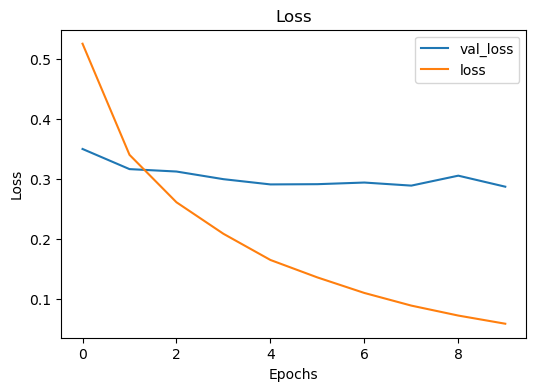

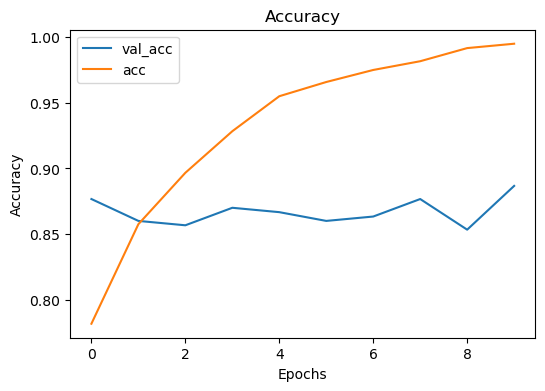

In [117]:
visualize_training_results(binary_res_history)

In [120]:
y_pred = binary_res_model.predict(cnn_binary_test)

10/10 [==============================] - 6s 651ms/step


In [121]:
print(classification_report(cnn_binary_test_labels, np.round(y_pred)))

              precision    recall  f1-score   support

           0       0.67      0.57      0.62        49
           1       0.89      0.94      0.92       251

   micro avg       0.86      0.88      0.87       300
   macro avg       0.78      0.76      0.77       300
weighted avg       0.85      0.88      0.87       300
 samples avg       0.86      0.88      0.87       300



C:\Users\lalyn\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Multiclass summary

| Model                  | Precision | Recall | F-1 Score |   |
|------------------------|-----------|--------|-----------|---|
| Basic Neural Network   | .23       | .27    | .15       |   |
| 1 hidden layer         | .29       | .30    | .28       |   |
| 2 hidden layer         | .03       | .20    | .06       |   |
| Grid Search            | .31       | .28    | .22       |   |
| L2 Regularization      | .35       | .35    | .29       |   |
| L1 Regularization      | .04       | .20    | .06       |   |
| Dropout Regularization | .03       | .20    | .06       |   |
| CNN Model              | .38       | .59    | .41       |   |
| ResNet50V2 Model       | .32       | .86    | .46       |   |
|                        |           |        |           |   |
|                        |           |        |           |   |
|                        |           |        |           |   |

# Binary summary

| Model                  | Precision | Recall | F-1 Score |   |
|------------------------|-----------|--------|-----------|---|
| Basic Neural Network   | .70       | .54    | .54       |   |
| 1 hidden layer         | .42       | .50    | .46       |   |
| 2 hidden layer         | .41       | .50    | .45       |   |
| Grid Search            | .64       | .65    | .65       |   |
| L2 Regularization      | .61       | .62    | .61       |   |
| L1 Regularization      | .42       | .50    | .46       |   |
| Dropout Regularization | .42       | .50    | .46       |   |
| CNN Model              | .54       | .50    | .47       |   |
| ResNet50V2 Model       | .78       | .76    | .77       |   |
|                        |           |        |           |   |
|                        |           |        |           |   |

|                        |           |        |           |   |

# All data resnet model

In [39]:
full_data_dir = 'data/train'

# Get all the data in the directory data/train (790 images), and reshape them
full_train_generator = ImageDataGenerator().flow_from_directory(
        full_data_dir, 
        target_size=(128, 128), batch_size=5656)

# Create the datasets
all_train_images, all_y_train = next(full_train_generator)


Found 5656 images belonging to 5 classes.


#### preview image labels

In [40]:
all_y_train

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.]], dtype=float32)

The labels are already in a format suited for modeling.

In [41]:
# preview shape
print(np.shape(all_train_images))
print(np.shape(all_y_train))

(5656, 128, 128, 3)
(5656, 5)


### reshape images

The images must be reshaped into a tensor before being input into a neural network model.

In [42]:
all_train_img_unrow = all_train_images.reshape(5656, -1)#.astype(uint8)

# Preview the shape of train_img_unrow
print(np.shape(all_train_img_unrow))

(5656, 49152)


#### normalize pixel values

In [43]:
all_train_img_unrow /= 255.

# Binary labeling

Label the data as belonging to one of 2 classes, healthy or diseased.

In [44]:
# make dataframe and preview
all_df = pd.DataFrame(all_y_train)
all_df

,0,1,2,3,4
0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,1.0,0.0
3,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...
5651,0.0,0.0,0.0,1.0,0.0
5652,0.0,0.0,0.0,1.0,0.0
5653,0.0,0.0,0.0,1.0,0.0
5654,0.0,0.0,0.0,0.0,1.0


In [45]:
# copy the dataframe
all_new=all_df.copy()

all_new


,0,1,2,3,4
0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,1.0,0.0
3,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...
5651,0.0,0.0,0.0,1.0,0.0
5652,0.0,0.0,0.0,1.0,0.0
5653,0.0,0.0,0.0,1.0,0.0
5654,0.0,0.0,0.0,0.0,1.0


In [47]:
all_new.loc[all_new[4]==1,"Healthy"]=1
all_new.loc[all_new[4]==0,"Healthy"]=0
all_new.loc[all_new[4]==1,"Diseased"]=0
all_new.loc[all_new[4]==0,"Diseased"]=1
all_new

,0,1,2,3,4,Healthy,Diseased
0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...
5651,0.0,0.0,0.0,1.0,0.0,0.0,1.0
5652,0.0,0.0,0.0,1.0,0.0,0.0,1.0
5653,0.0,0.0,0.0,1.0,0.0,0.0,1.0
5654,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [48]:
all_new.drop([0, 1, 2, 3, 4], axis=1, inplace=True)

In [49]:
all_new.head()

,Healthy,Diseased
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0


In [50]:
# check for any null entries
all_new.isnull().sum()

Healthy     0
Diseased    0
dtype: int64

In [51]:
all_new['Healthy'].sum()


316.0

In [52]:
all_new['Diseased'].sum()


5340.0

In [53]:
316 / 5340

0.05917602996254682

<AxesSubplot:>

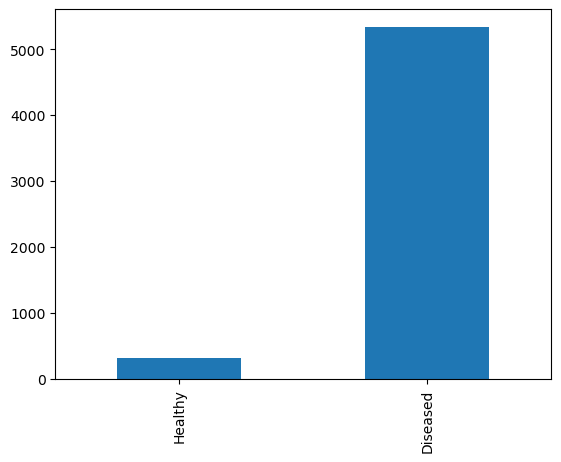

In [54]:
#new['Healthy'].plot(kind='bar')
all_new.sum().plot(kind='bar')

In [55]:
all_cnn_train, all_cnn_test, all_cnn_train_labels, all_cnn_test_labels= train_test_split(all_train_images, all_y_train, test_size=0.2, random_state=42,shuffle=True)


In [56]:
all_cnn_binary_train, all_cnn_binary_test, all_cnn_binary_train_labels, all_cnn_binary_test_labels= train_test_split(all_train_images, all_new, test_size=0.2, random_state=42,shuffle=True)


In [31]:
from keras.applications import ResNet50V2

In [32]:
resnet = ResNet50V2(weights='imagenet', 
                 include_top=False, 
                 input_shape=(128, 128, 3))

In [33]:
resnet.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 134, 134, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 64, 64, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 66, 66, 64)           0         ['conv1_conv[0][0]']          
                                                                                         

 tchNormalization)                                                                                
                                                                                                  
 conv2_block3_preact_relu (  (None, 32, 32, 256)          0         ['conv2_block3_preact_bn[0][0]
 Activation)                                                        ']                            
                                                                                                  
 conv2_block3_1_conv (Conv2  (None, 32, 32, 64)           16384     ['conv2_block3_preact_relu[0][
 D)                                                                 0]']                          
                                                                                                  
 conv2_block3_1_bn (BatchNo  (None, 32, 32, 64)           256       ['conv2_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
          

 conv3_block2_1_relu (Activ  (None, 16, 16, 128)          0         ['conv3_block2_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv3_block2_2_pad (ZeroPa  (None, 18, 18, 128)          0         ['conv3_block2_1_relu[0][0]'] 
 dding2D)                                                                                         
                                                                                                  
 conv3_block2_2_conv (Conv2  (None, 16, 16, 128)          147456    ['conv3_block2_2_pad[0][0]']  
 D)                                                                                               
                                                                                                  
 conv3_block2_2_bn (BatchNo  (None, 16, 16, 128)          512       ['conv3_block2_2_conv[0][0]'] 
 rmalizati

                                                                                                  
 conv3_block4_3_conv (Conv2  (None, 8, 8, 512)            66048     ['conv3_block4_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block4_out (Add)      (None, 8, 8, 512)            0         ['max_pooling2d_1[0][0]',     
                                                                     'conv3_block4_3_conv[0][0]'] 
                                                                                                  
 conv4_block1_preact_bn (Ba  (None, 8, 8, 512)            2048      ['conv3_block4_out[0][0]']    
 tchNormalization)                                                                                
                                                                                                  
 conv4_blo

 D)                                                                 0]']                          
                                                                                                  
 conv4_block3_1_bn (BatchNo  (None, 8, 8, 256)            1024      ['conv4_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block3_1_relu (Activ  (None, 8, 8, 256)            0         ['conv4_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block3_2_pad (ZeroPa  (None, 10, 10, 256)          0         ['conv4_block3_1_relu[0][0]'] 
 dding2D)                                                                                         
          

 conv4_block5_2_relu (Activ  (None, 8, 8, 256)            0         ['conv4_block5_2_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block5_3_conv (Conv2  (None, 8, 8, 1024)           263168    ['conv4_block5_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv4_block5_out (Add)      (None, 8, 8, 1024)           0         ['conv4_block4_out[0][0]',    
                                                                     'conv4_block5_3_conv[0][0]'] 
                                                                                                  
 conv4_block6_preact_bn (Ba  (None, 8, 8, 1024)           4096      ['conv4_block5_out[0][0]']    
 tchNormal

                                                                                                  
 conv5_block2_preact_relu (  (None, 4, 4, 2048)           0         ['conv5_block2_preact_bn[0][0]
 Activation)                                                        ']                            
                                                                                                  
 conv5_block2_1_conv (Conv2  (None, 4, 4, 512)            1048576   ['conv5_block2_preact_relu[0][
 D)                                                                 0]']                          
                                                                                                  
 conv5_block2_1_bn (BatchNo  (None, 4, 4, 512)            2048      ['conv5_block2_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_blo

In [34]:
#instantiate and train model  -12288 input shape if 64 pix   196608 if 256     49152
np.random.seed(42)
res_model = models.Sequential()
res_model.add(resnet)
res_model.add(layers.Flatten())
res_model.add(layers.Dense(132, activation='relu'))
res_model.add(layers.Dense(5, activation='sigmoid'))


In [35]:
for layer in res_model.layers:
    print(layer.name, layer.trainable)
    
# Similarly, you can check how many trainable weights are in the model
print(len(res_model.trainable_weights))

resnet50v2 True
flatten True
dense True
dense_1 True
176


In [36]:
resnet.trainable = False

In [37]:
for layer in res_model.layers:
    print(layer.name, layer.trainable)
    
# Similarly, we can check how many trainable weights are in the model
print(len(res_model.trainable_weights))

resnet50v2 False
flatten True
dense True
dense_1 True
4


In [38]:
res_model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=2e-5),
              metrics=['acc'])

In [39]:
res_history = res_model.fit(cnn_train,
                    cnn_train_labels,
                    steps_per_epoch=27,
                    epochs=10,
                    validation_data=(cnn_test, cnn_test_labels),
                    validation_steps=10)



Epoch 1/10


27/27 [==============================] - 138s 5s/step - loss: 1.4226 - acc: 0.5091 - val_loss: 1.2178 - val_acc: 0.5627
Epoch 2/10
27/27 [==============================] - 149s 6s/step - loss: 0.9954 - acc: 0.6320 - val_loss: 1.0900 - val_acc: 0.6113
Epoch 3/10
27/27 [==============================] - 141s 5s/step - loss: 0.8214 - acc: 0.6930 - val_loss: 1.0694 - val_acc: 0.6140
Epoch 4/10
27/27 [==============================] - 173s 7s/step - loss: 0.6950 - acc: 0.7445 - val_loss: 1.0508 - val_acc: 0.6316
Epoch 5/10
27/27 [==============================] - 132s 5s/step - loss: 0.5903 - acc: 0.7933 - val_loss: 1.0387 - val_acc: 0.6352
Epoch 6/10
27/27 [==============================] - 117s 4s/step - loss: 0.5072 - acc: 0.8309 - val_loss: 1.0337 - val_acc: 0.6413
Epoch 7/10
27/27 [==============================] - 116s 4s/step - loss: 0.4408 - acc: 0.8590 - val_loss: 1.0385 - val_acc: 0.6405
Epoch 8/10
27/27 [==============================] - 115s 4s/step - loss: 0.3801 -

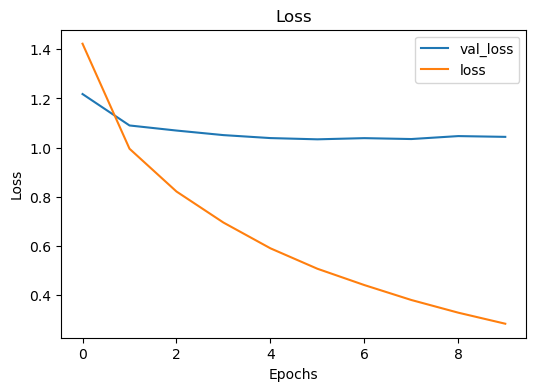

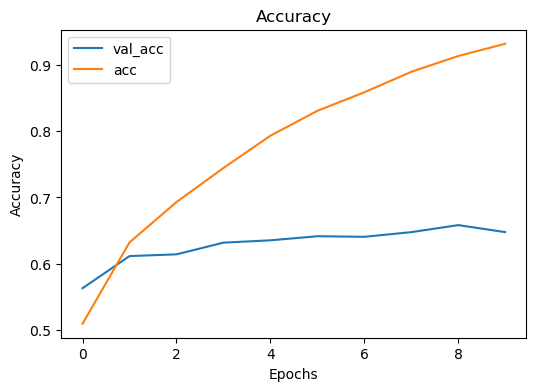

In [40]:
visualize_training_results(res_history)

In [41]:
y_pred = res_model.predict(cnn_test)

36/36 [==============================] - 28s 688ms/step


In [99]:
print(classification_report(cnn_test_labels, np.round(y_pred)))

              precision    recall  f1-score   support

           0       0.26      0.87      0.40        55
           1       0.28      0.82      0.42        61
           2       0.32      0.75      0.45        69
           3       0.40      0.94      0.56        66
           4       0.34      0.92      0.49        49

   micro avg       0.32      0.86      0.46       300
   macro avg       0.32      0.86      0.46       300
weighted avg       0.32      0.86      0.47       300
 samples avg       0.35      0.86      0.48       300



C:\Users\lalyn\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# pretrained binary model

In [42]:
#instantiate and train model  -12288 input shape if 64 pix   196608 if 256     49152
np.random.seed(42)
binary_res_model = models.Sequential()
binary_res_model.add(resnet)
binary_res_model.add(layers.Flatten())
binary_res_model.add(layers.Dense(132, activation='relu'))
binary_res_model.add(layers.Dense(2, activation='sigmoid'))


In [43]:
for layer in binary_res_model.layers:
    print(layer.name, layer.trainable)
    
# Similarly, you can check how many trainable weights are in the model
print(len(binary_res_model.trainable_weights))

resnet50v2 False
flatten_1 True
dense_2 True
dense_3 True
4


In [44]:
resnet.trainable = False

In [45]:
for layer in binary_res_model.layers:
    print(layer.name, layer.trainable)
    
# Similarly, we can check how many trainable weights are in the model
print(len(binary_res_model.trainable_weights))

resnet50v2 False
flatten_1 True
dense_2 True
dense_3 True
4


In [46]:
binary_res_model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=2e-5),
              metrics=['acc'])

In [47]:
binary_res_history = binary_res_model.fit(cnn_binary_train,
                    cnn_binary_train_labels,
                    steps_per_epoch=27,
                    epochs=10,
                    validation_data=(cnn_binary_test, cnn_binary_test_labels),                   
                    validation_steps=10)



Epoch 1/10
27/27 [==============================] - 133s 5s/step - loss: 0.3232 - acc: 0.9056 - val_loss: 0.2003 - val_acc: 0.9470
Epoch 2/10
27/27 [==============================] - 115s 4s/step - loss: 0.1679 - acc: 0.9478 - val_loss: 0.1768 - val_acc: 0.9496
Epoch 3/10
27/27 [==============================] - 118s 4s/step - loss: 0.1340 - acc: 0.9525 - val_loss: 0.1739 - val_acc: 0.9479
Epoch 4/10
27/27 [==============================] - 114s 4s/step - loss: 0.1086 - acc: 0.9593 - val_loss: 0.1665 - val_acc: 0.9452
Epoch 5/10
27/27 [==============================] - 116s 4s/step - loss: 0.0917 - acc: 0.9677 - val_loss: 0.1657 - val_acc: 0.9479
Epoch 6/10
27/27 [==============================] - 140s 5s/step - loss: 0.0776 - acc: 0.9737 - val_loss: 0.1672 - val_acc: 0.9470
Epoch 7/10
27/27 [==============================] - 577s 22s/step - loss: 0.0664 - acc: 0.9777 - val_loss: 0.1691 - val_acc: 0.9461
Epoch 8/10
27/27 [==============================] - 115s 4s/step - loss: 0.0562 - 

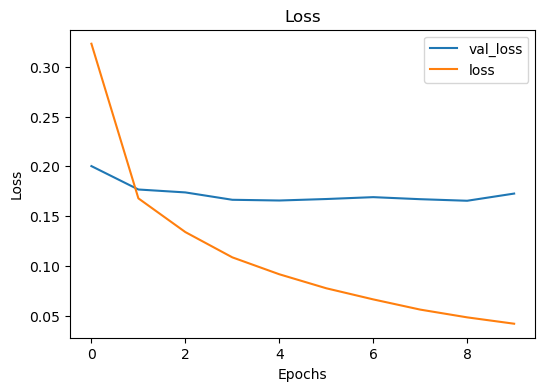

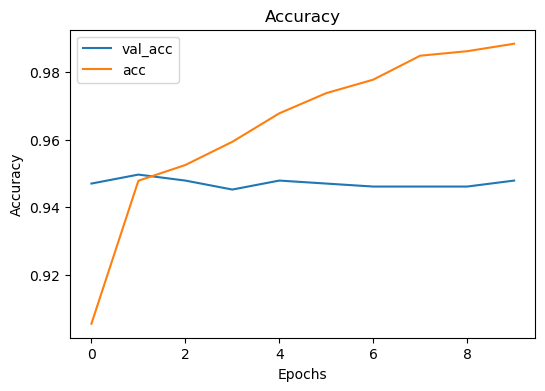

In [48]:
visualize_training_results(binary_res_history)

In [49]:
y_pred = binary_res_model.predict(cnn_binary_test)

36/36 [==============================] - 24s 616ms/step


In [50]:
print(classification_report(cnn_binary_test_labels, np.round(y_pred)))

              precision    recall  f1-score   support

           0       0.68      0.23      0.34        66
           1       0.95      0.99      0.97      1066

   micro avg       0.95      0.95      0.95      1132
   macro avg       0.82      0.61      0.66      1132
weighted avg       0.94      0.95      0.94      1132
 samples avg       0.94      0.95      0.94      1132



C:\Users\lalyn\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
